In this notebook I try and test different I/O methods to read fits files to load the spectra. I also look a good way to subsample the spectra.

In [1]:
import numpy as np
import fitsio
from fitsio import FITS, FITSHDR
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Check fitsio was properly installed
fitsio.test.test()

testNonStandardKeyValue (fitsio.test.TestWarnings) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
testAsciiTableWriteRead (fitsio.test.TestReadWrite) ... ok
testBz2Read (fitsio.test.TestReadWrite) ... ok
testChecksum (fitsio.test.TestReadWrite) ... ok
testExtVer (fitsio.test.TestReadWrite) ... ok
testGZIPTileCompressedWriteRead (fitsio.test.TestReadWrite) ... ok
testGZWriteRead (fitsio.test.TestReadWrite) ... ok
testHCompressTileCompressedWriteRead (fitsio.test.TestReadWrite) ... ok
testHeaderWriteRead (fitsio.test.TestReadWrite) ... ok
testImageSlice (fitsio.test.TestReadWrite) ... ok
testImageWriteRead (fitsio.test.TestReadWrite) ... ok
testImageWriteReadFromDims (fitsio.test.TestReadWrite) ... ok
testImageWriteReadFromDimsChunks (fitsio.test.TestReadWrite) ... ok
testLowerUpper (fitsio.test.TestReadWrite) ... ok
testMoveByName (fitsio.test.TestReadWrite) ... ok
testPLIOTileCompressedWriteRead (fitsio.test.TestReadWrite) ... ok

In [63]:
%%time 
filename = 'data/spectra1000/spec-4216-55477-0204.fits'
data = np.array(Table.read(filename, hdu=1)['loglam','flux'])
# Astropy unified fits io

CPU times: user 84 ms, sys: 15 µs, total: 84 ms
Wall time: 85.7 ms


In [4]:
%%time
filename = 'data/spectra1000/spec-4216-55477-0234.fits'
data = fitsio.read(filename, columns=['loglam','flux'])
# Fitio input utility

CPU times: user 20.4 ms, sys: 3.39 ms, total: 23.7 ms
Wall time: 33.1 ms


Apparently, the ```fitsio``` library is a little faster. Also, it returns a numpy array directly, rather than a heavy astropy Table

------------------------
Guess: loading the ```loglam``` column is unnecessary because it's always the same array. We need to verify this.

In [17]:
from glob import glob
filelist = glob('data/spectra1000/*.fits')
mins, maxs = [], []            
for file in filelist[:10]: # Loop first 10 files
    lam = fitsio.read(file, ext=1, columns='loglam')
    mins.append(lam.min())
    maxs.append(lam.max())
    print(lam.min(), lam.max(), lam.size)
print('Higher left endoint: {}'.format(max(mins)))
print('Lower right endpoint: {}'.format(min(maxs)))

3.5587 4.0168 4582
3.5522 4.0141 4620
3.5521 4.0148 4628
3.5511 4.0145 4635
3.5522 4.0141 4620
3.5597 4.0163 4567
3.5582 4.0165 4584
3.5517 4.0143 4627
3.5574 4.0153 4580
3.5521 4.0139 4619
Higher left endoint: 3.5597000122070312
Lower right endpoint: 4.013899803161621


Clearly, I was wrong. Every file has its own length and the wavelength limits are not the same

Now let's try downsampling the spectrum (because 4000 points would need too much memory and training will be slow)

3.5520999431610107 4.0137076809202465


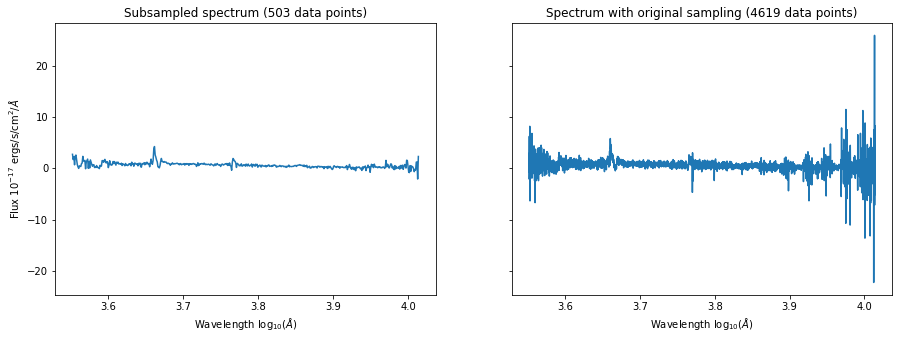

In [13]:
from scipy.signal import resample

data = fitsio.read(filename, ext=1, columns=['loglam','flux'])
# WATCH OUT: The endianness of the arrays must be set to little endian
# before using scipy.signal subsample
loglam = np.asarray(data['loglam'], dtype=np.dtype('<f4'))
flux = np.asarray(data['flux'], dtype=np.dtype('<f4'))

# This is very easy, but behind the scenes is using an
# FFT so I don't know if this will scale reasonably
sub_flux, sub_loglam = resample(flux, 503, t=loglam)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
ax[0].plot(sub_loglam, sub_flux)
ax[1].plot(data['loglam'], data['flux'])
ax[0].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[0].set_title(r'Subsampled spectrum (503 data points)')
ax[1].set_title(r'Spectrum with original sampling ({} data points)'.format(len(flux)))
# print(sub_loglam.min(), sub_loglam.max())

As we can see, in the subsampled spectrum the noise is greatly reduced while still showing the main features.
Now, as we saw earlier, the wavelength endopoints do not coincide for every spectrum. Hence, I would wish to standarize the spectra in a single wavelength axis for all of the data. This can be achieved through interpolation.

Execution times: 
Method 1: 1.7147064208984375 milliseconds
Method 2: 0.2701282501220703 milliseconds


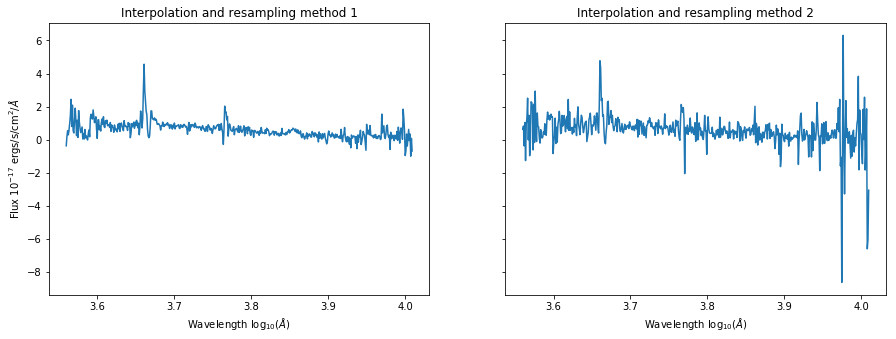

In [33]:
from scipy.interpolate import interp1d
from time import time

# Let's say we want to restrict the spectrum to the interval 3.56-4.01
ispec = interp1d(loglam, flux, kind='cubic')

# Method 1:
start1 = time()
loglam_1_int = np.linspace(3.56, 4.01, len(loglam), endpoint=True)
flux_1_int  = ispec(loglam_1_int)
sub_flux_1_int,  sub_loglam_1_int = resample(flux_1_int, t=loglam_1_int, num=503)
time_taken1 = time() - start1

# Method 2:
start2 = time()
sub_loglam_2_int = np.linspace(3.56, 4.01, 503, endpoint=True)
sub_flux_2_int = ispec(sub_loglam_2_int)
time_taken2 = time() - start2

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2,sharey=True, figsize=(15,5))
ax[0].plot(sub_loglam_1_int, sub_flux_1_int)
ax[1].plot(sub_loglam_2_int, sub_flux_2_int)
ax[0].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[0].set_title('Interpolation and resampling method 1')
ax[1].set_title('Interpolation and resampling method 2');
print('Execution times: ')
print('Method 1: {} milliseconds'.format(time_taken1 * 1e3))
print('Method 2: {} milliseconds'.format(time_taken2 * 1e3))

Here we have two choices:
1. Interpolating  with the same number of points and then resampling afterwards
2. Interpolating and resampling directly with ```interp1d```


While the second one may seem quicker, the first may be more robust.

-------
The next thing to incorporate to the pipeline is the renormalization. Following [Busca (2018)](https://arxiv.org/abs/1808.09955):
>Large variations in the
inputs to neural networks, in our case due to the distribution
of quasar luminosity, are known to slow down learning. To
reduce this problem we renormalize spectra by subtracting
to each flux its weighted mean and dividing the result by
its weighted root-mean-square, using the inverse variances
available with each spectrum as weights.

I interpret this as the the following. If $f_i$ is the $i-$th flux point and $1/\sigma_i^2$ it's corresponding inverse variance, then the renormalized flux $f_i^{\prime}$ is 


In [64]:
%%latex
\begin{equation}
 f_i^{\prime} = \frac{f_i(1 - 1/\sigma_i^2)}{\sqrt{\sum_{j}{\frac{f_i^2}{\sigma_j^2}}}}
\end{equation}

<IPython.core.display.Latex object>

Of course, this has to be done before resampling

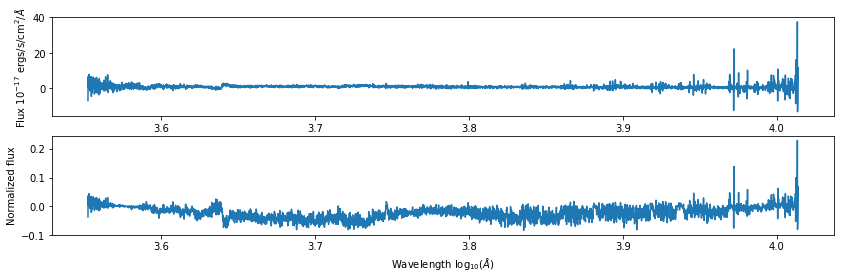

In [2]:
data = fitsio.read('data/spectra1000/spec-4216-55477-0202.fits', columns=['loglam', 'flux', 'ivar'], dtype=np.float32)
normflux = (data['flux'] - data['flux'] * data['ivar']) / np.sqrt(np.sum(data['ivar'] * data['flux'] ** 2))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 4))
ax[0].plot(data['loglam'], data['flux'])
ax[1].plot(data['loglam'], normflux)
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[1].set_ylabel(r'Normalized flux');

This doesn't look good. The normalization seems to produce a noisier spectrum and worse is that __emission lines were turned into absorption lines!!__   
  A possible fix is to just invert the overall sign...

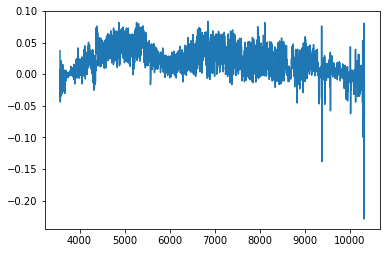

In [3]:
%matplotlib inline
plt.plot(10 ** data['loglam'], -normflux)

This is still not satisfactory, so taking a quick glance at the [QuasarNET code](https://github.com/ngbusca/QuasarNET/blob/master/py/quasarnet/io.py) I found they were doing something like this:

0


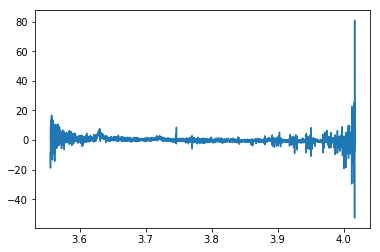

In [8]:
data = fitsio.read('data/spectra1000/spec-4296-55499-0684.fits', columns=['loglam', 'flux', 'ivar'], dtype=np.float32)

mdata = np.average(data['flux'], weights = data['ivar'])
sdata = np.average((data['flux'] - mdata) ** 2, weights = data['ivar'])
sdata = np.sqrt(sdata)

# This is for removing points with zero flux 
w = sdata == 0
data['flux'] = data['flux'][~w]
mdata = mdata[~w]
sdata = sdata[~w]
# -------------------------------------------
normflux = data['flux'] - mdata
normflux /= sdata
plt.plot(data['loglam'], normflux);
print(w.sum())

Ahh this looks much better!

In [56]:
%autoreload 2
import pipeline as io
spec = fitsio.read('data/spectra1000/spec-4216-55477-0210.fits', columns=['flux', 'loglam'], dtype=np.float32)
io.crop_and_subsample(spec, 503, (3.56, 4.01))

TypeError: only size-1 arrays can be converted to Python scalars

In [38]:
from scipy.signal import resample
resample